In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler

import optuna
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from optuna.exceptions import TrialPruned
from darts.models import BlockRNNModel
from darts.metrics import mape, mae, rmse

c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [17]:
sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2014-01-01", end="2024-01-01")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)
weekly_price = df["Close"].resample("W-FRI").last()

C:\Users\USER\AppData\Local\Temp\ipykernel_34600\223424636.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [18]:
# Weekly returns
weekly_ret = weekly_price.pct_change().fillna(0)

# wrap in Darts
rets = TimeSeries.from_series(weekly_ret, fill_missing_dates=True, freq="W")
rets = fill_missing_values(rets)

In [19]:
# train/test split
train_rets, test_rets = rets.split_before(pd.Timestamp("2023-01-01"))

In [20]:
def get_splits(series, start_year=2014, end_year=2022):
    splits = []
    for y in range(start_year, end_year):
        train_end = pd.Timestamp(f"{y}-12-31")
        val_start = train_end + pd.Timedelta(days=1)
        val_end   = pd.Timestamp(f"{y+1}-12-31")
        tr = series.slice(series.start_time(), train_end)
        vr = series.slice(val_start,             val_end)
        splits.append((tr, vr))
    return splits

splits = get_splits(train_rets, 2014, 2022)

In [22]:
min_len = min(len(tr) for tr, _ in splits)
max_in  = min_len - 1

def objective(trial):
    ic = trial.suggest_int("input_chunk_length", 4, max_in)
    hd = trial.suggest_categorical("hidden_dim", [64,128,256])
    nl = trial.suggest_int("n_rnn_layers", 1, 3)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    do = trial.suggest_float("dropout", 0.0, 0.5)

    errs = []
    for idx, (tr, vr) in enumerate(splits):
        # scale returns
        sc = Scaler()
        tr_s = sc.fit_transform(tr)
        vr_s = sc.transform(vr)

        # lightning trainer
        es = EarlyStopping(monitor="val_loss", patience=5, mode="min")
        trainer = pl.Trainer(
            accelerator="gpu", devices=1,
            precision=64, max_epochs=50,
            callbacks=[es],
            enable_checkpointing=False,
            enable_progress_bar=False, logger=False
        )

        # model
        m = BlockRNNModel(
            model="LSTM",
            input_chunk_length=ic,
            output_chunk_length=1,
            hidden_dim=hd,
            n_rnn_layers=nl,
            dropout=do,
            batch_size=32,
            optimizer_kwargs={"lr": lr},
            nr_epochs_val_period=1,
            random_state=42
        )
        m.fit(series=tr_s, val_series=vr_s, trainer=trainer, verbose=False)

        # forecast returns
        pr = m.predict(n=len(vr_s), series=tr_s)
        pr_un = sc.inverse_transform(pr)
        errs.append(mape(vr, pr_un))

        trial.report(errs[-1], idx)
        if trial.should_prune():
            raise TrialPruned()

    return float(np.mean(errs))

In [23]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2025-07-30 20:16:31,495] A new study created in memory with name: no-name-59a091bb-c86f-4b4b-9963-adfacc0022a2
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type     

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:16:35,595] Trial 0 finished with value: 174.58744197184112 and parameters: {'input_chunk_length': 6, 'hidden_dim': 64, 'n_rnn_layers': 2, 'lr': 0.006686812470438329, 'dropout': 0.02376142448380819}. Best is trial 0 with value: 174.58744197184112.
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSEL

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:16:44,105] Trial 1 finished with value: 184.94228932330077 and parameters: {'input_chunk_length': 15, 'hidden_dim': 128, 'n_rnn_layers': 2, 'lr': 0.0010661392650176025, 'dropout': 0.4662001270494038}. Best is trial 0 with value: 174.58744197184112.
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MS

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (cuda), 

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:16:51,843] Trial 2 finished with value: 160.5890560800653 and parameters: {'input_chunk_length': 8, 'hidden_dim': 128, 'n_rnn_layers': 2, 'lr': 0.0005231875435640458, 'dropout': 0.46154973725916637}. Best is trial 2 with value: 160.5890560800653.
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSEL

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:04,023] Trial 3 finished with value: 229.83951846973773 and parameters: {'input_chunk_length': 33, 'hidden_dim': 128, 'n_rnn_layers': 3, 'lr': 0.00019505750221366678, 'dropout': 0.4124162557931826}. Best is trial 2 with value: 160.5890560800653.
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MS

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:12,714] Trial 4 finished with value: 318.2627708929439 and parameters: {'input_chunk_length': 7, 'hidden_dim': 256, 'n_rnn_layers': 3, 'lr': 0.009079160726632502, 'dropout': 0.3098505547513547}. Best is trial 2 with value: 160.5890560800653.
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELos

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:12,920] Trial 5 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              |

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:13,789] Trial 6 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              |

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:15,834] Trial 7 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              |

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:23,781] Trial 8 finished with value: 172.17132907520025 and parameters: {'input_chunk_length': 13, 'hidden_dim': 128, 'n_rnn_layers': 3, 'lr': 0.000821030178639892, 'dropout': 0.3156266598240759}. Best is trial 2 with value: 160.5890560800653.
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSEL

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:24,055] Trial 9 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17798936474972846 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17798936474972846 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17798936474972846 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17798936474972846 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17798936474972846 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:26,555] Trial 10 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2502792834467147 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:26,781] Trial 11 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:28,508] Trial 12 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16082589249158685 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:28,832] Trial 13 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:34,367] Trial 14 finished with value: 210.78160773956688 and parameters: {'input_chunk_length': 4, 'hidden_dim': 128, 'n_rnn_layers': 3, 'lr': 0.001985738996129871, 'dropout': 0.28476794818812623}. Best is trial 2 with value: 160.5890560800653.
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSE

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:34,699] Trial 15 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:47,283] Trial 16 finished with value: 167.99335806999522 and parameters: {'input_chunk_length': 22, 'hidden_dim': 256, 'n_rnn_layers': 2, 'lr': 0.0018849105568091921, 'dropout': 0.16966089000734005}. Best is trial 2 with value: 160.5890560800653.
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | M

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:47,632] Trial 17 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10273527622940765 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:47,845] Trial 18 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:48,494] Trial 19 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.09772251840831475 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:48,705] Trial 20 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:55,138] Trial 21 finished with value: 167.352321251141 and parameters: {'input_chunk_length': 12, 'hidden_dim': 128, 'n_rnn_layers': 3, 'lr': 0.0007439628752575947, 'dropout': 0.28906057027491605}. Best is trial 2 with value: 160.5890560800653.
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSE

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:57,059] Trial 22 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:57,750] Trial 23 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:17:58,387] Trial 24 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:18:04,934] Trial 25 finished with value: 131.1692747094865 and parameters: {'input_chunk_length': 4, 'hidden_dim': 256, 'n_rnn_layers': 2, 'lr': 0.003605941924856457, 'dropout': 0.4337545920536317}. Best is trial 25 with value: 131.1692747094865.
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSEL

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:18:05,178] Trial 26 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:18:05,387] Trial 27 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:18:10,049] Trial 28 finished with value: 118.9342749574023 and parameters: {'input_chunk_length': 11, 'hidden_dim': 64, 'n_rnn_layers': 2, 'lr': 0.0013050120613969992, 'dropout': 0.4941868132628894}. Best is trial 28 with value: 118.9342749574023.
C:\Users\USER\AppData\Local\Temp\ipykernel_34600\1213288081.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSE

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-30 20:18:10,243] Trial 29 pruned. 


In [24]:
best = study.best_params
print("best:", best)

best: {'input_chunk_length': 11, 'hidden_dim': 64, 'n_rnn_layers': 2, 'lr': 0.0013050120613969992, 'dropout': 0.4941868132628894}


### Fit

In [25]:
sc_full = Scaler()
train_rets_s = sc_full.fit_transform(train_rets)

<Axes: xlabel='time'>

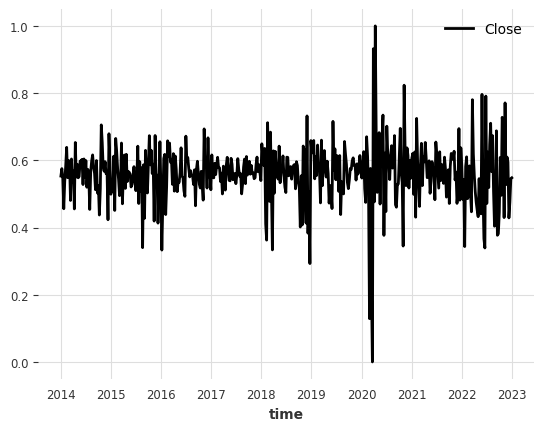

In [36]:
train_rets_s.plot()

In [52]:
model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=best["input_chunk_length"],
    output_chunk_length=1,
    hidden_dim=best["hidden_dim"],
    n_rnn_layers=best["n_rnn_layers"],
    dropout=best["dropout"],
    batch_size=32,
    n_epochs=100,
    optimizer_kwargs={"lr": best["lr"]},
    nr_epochs_val_period=5,
    pl_trainer_kwargs={"accelerator":"gpu","devices":1},
    random_state=42
)
model.fit(train_rets_s, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=64, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.4941868132628894, activation=ReLU, input_chunk_length=11, output_chunk_length=1, batch_size=32, n_epochs=100, optimizer_kwargs={'lr': 0.0013050120613969992}, nr_epochs_val_period=5, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': 1}, random_state=42)

In [65]:
h = len(test_rets)
ret_forecast = model.predict(n=h, series=train_rets_s)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='time'>

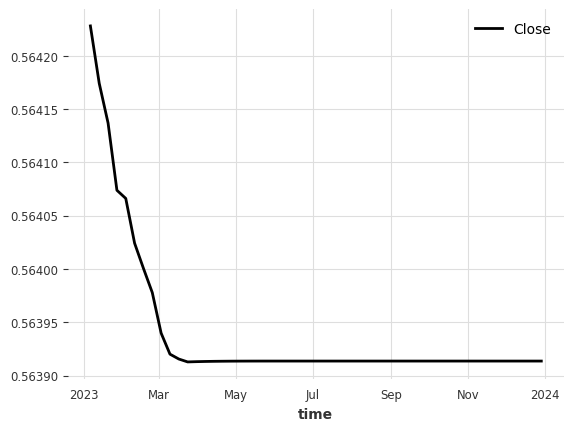

In [70]:
# train_rets_s.plot()
ret_forecast.plot()